# 夏秋雨 2024112200

在动量空间中，在某处的动量体积元内出现粒子的概率
$$
\begin{align}
    A &= \int_0^{+\infty} f(k)dk
    \\
    \frac{d\omega}{A} = \frac{f(k)k^2\sin\theta dk d\theta d\phi}{A} &= p(k) p(\theta) p(\phi) dk d\theta d\phi
    \\
    &\Leftrightarrow
    \\
    f(k) k^2 \sin\theta / A &= p(k) p(\theta) p(\phi)
\end{align}
$$
由此定义如下函数
$$
\begin{align}
    p(k) &= 4\pi k^2 f(k) / A
    \\
    p(\theta) &= \frac{\sin\theta}{2}
    \\
    p(\phi) &= \frac{1}{2\pi}
\end{align}
$$
显然
1. $\phi$可以使用均匀抽样
2. k使用舍选
3. $\theta$使用反函数法

$$
\begin{align}
    G(\theta) &= \int_0^\theta \frac{\sin\theta}{2}d\theta
    \\
    &= \frac{1 - \cos\theta}{2}
    \\
    &= Y
    \\
    \because Y &\sim U(0, 1)
    \\
    \therefore \cos\theta &= 1 - 2Y \sim U(-1, 1)
\end{align}
$$

In [25]:
import numpy as np
from scipy.integrate import quad

class FourMomentumSampling:
    @staticmethod
    def boson_einstein_dis(k, temper=150, mass=135):
        energy = np.sqrt(k ** 2 + mass ** 2)
        return 1 / (np.exp(energy / temper) - 1)
    
    @staticmethod
    def sample_phi(num=1000):
        return np.random.uniform(0, 2 * np.pi, num)
    
    @staticmethod
    def sample_theta(num=1000):
        cos_theta = np.random.uniform(-1, 1, num)
        return np.arccos(cos_theta)
    
    @staticmethod
    def sample_k(num=1000, max_range=2000, temper=150, mass=135):
        k_shuffled = []
        A = quad(FourMomentumSampling.boson_einstein_dis, 0, max_range, args=(temper, mass))[0]

        # 确定y的最大值
        x_get_y_max = np.linspace(0, max_range, max_range * 10)
        y_max = np.max(4 * np.pi * x_get_y_max ** 2 * FourMomentumSampling.boson_einstein_dis(x_get_y_max, temper=temper, mass=mass) / A)
        
        while len(k_shuffled) < num:
            x = np.random.uniform(0, max_range)
            y = np.random.uniform(0, y_max)
            if y < 4 * np.pi * x ** 2 * FourMomentumSampling.boson_einstein_dis(x, temper=temper, mass=mass) / A:
                k_shuffled.append(x)
            
        return np.array(k_shuffled)

In [26]:
ks = FourMomentumSampling.sample_k(num=100000)
thetas = FourMomentumSampling.sample_theta(num=100000)
phis = FourMomentumSampling.sample_phi(num=100000)

# K的分布

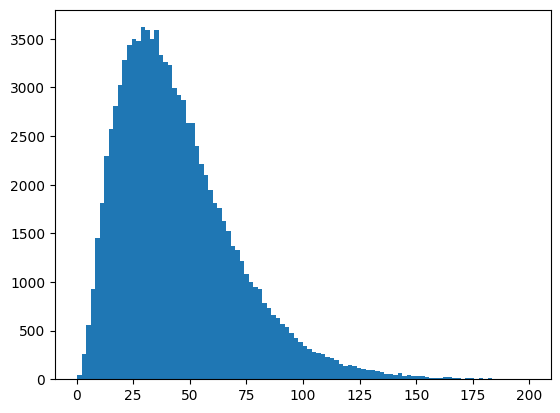

(100000,)

In [27]:
import matplotlib.pyplot as plt
_ = plt.hist(ks / 10, bins=100)
plt.show()
ks.shape

# theta的分布

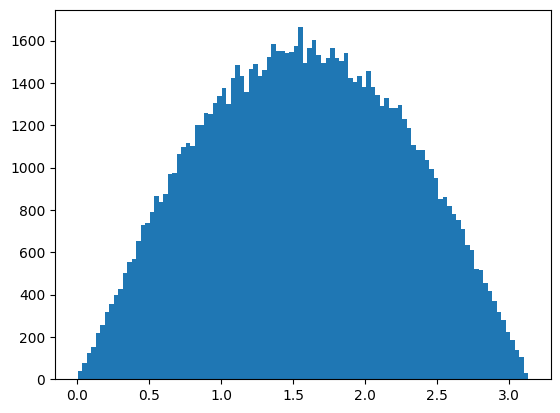

In [28]:
_ = plt.hist(thetas, bins=100)

# phi的分布

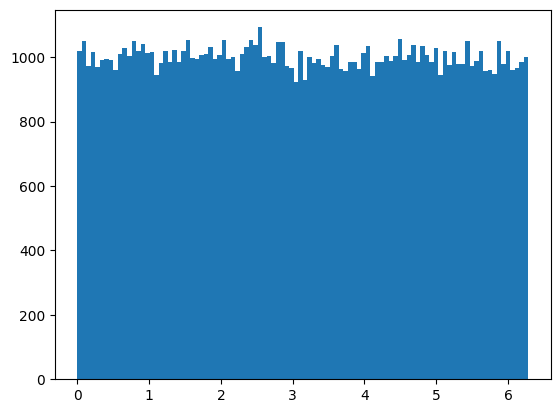

In [29]:
_ = plt.hist(phis, bins=100)

In [30]:
class ConvertPolar2Descartes:
    @staticmethod
    def get_x(r, theta, phi):
        return r * np.sin(theta) * np.sin(phi)
    
    @staticmethod
    def get_y(r, theta, phi):
        return r * np.sin(theta) * np.cos(phi)
    
    @staticmethod
    def get_z(r, theta):
        return r * np.cos(theta)

In [31]:
kxs = []
kys = []
kzs = []
for k, phi, theta in zip(ks, phis, thetas):
    kxs.append(ConvertPolar2Descartes.get_x(k, theta, phi))
    kys.append(ConvertPolar2Descartes.get_y(k, theta, phi))
    kzs.append(ConvertPolar2Descartes.get_z(k, theta))

# 画一个二维极坐标的图，视角是从上往下看（也就是没有theta参数）

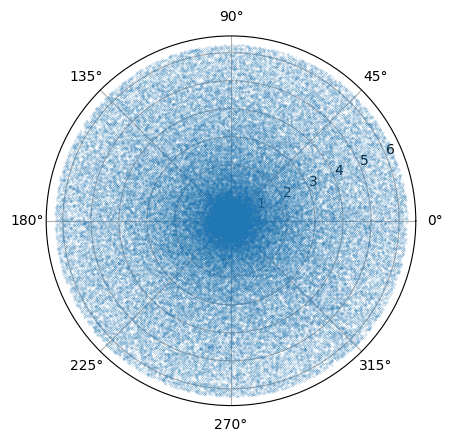

In [32]:
plt.polar(ks, phis, "o", ms=0.1)

# 对比这个二维的极坐标图，可以看到和玻色爱因斯坦分布的曲线都是一样的中间大，外边小

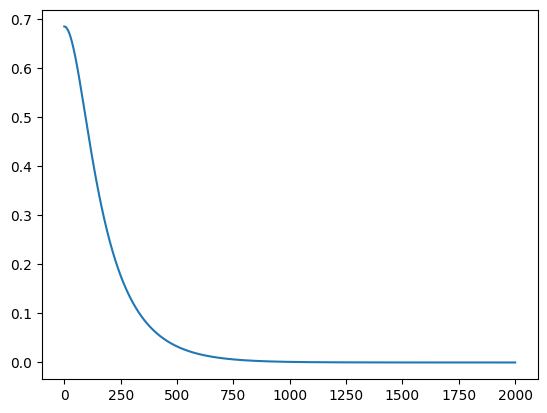

In [33]:
x = np.linspace(0, 2000, 2000)
plt.plot(x, FourMomentumSampling.boson_einstein_dis(x))

# 画一个3D图
下面的cell代码来自deepseek

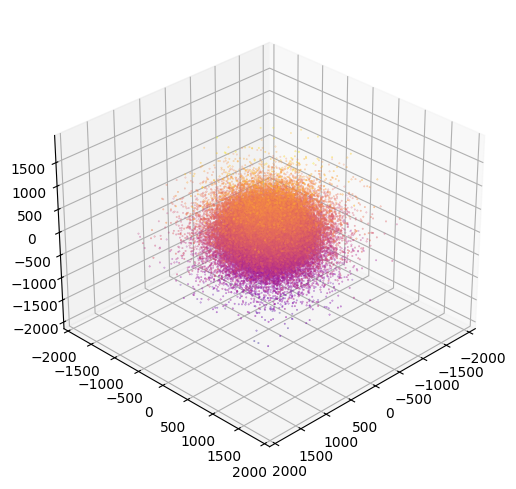

In [34]:
# 创建三维坐标系
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(111, projection='3d')

# 绘制散点图
ax.scatter3D(kxs, kys, kzs, c=kzs, cmap='plasma', s=0.1)

# 调整视角
ax.view_init(elev=30, azim=45)

# 显示图形
plt.show()

# 扔硬币
使用beta函数作为先验

$$
p(\theta) = \theta^{\alpha - 1} (1 - \theta)^{\beta - 1}
$$

使用二项分布函数作为似然

$$
P(n \ in \ m | \theta) \propto \theta^m (1 - \theta)^{n-m}
$$

显然，由于贝叶斯定理

$$
P(\theta | n \ in \ m) \propto \theta^{\alpha + m - 1}(1 - \theta)^{\beta + m +n-1}
$$

In [35]:
from scipy.stats import beta
import numpy as np
import matplotlib.pyplot as plt

def plot_beta(a, b):
    """
    这个相当于先验函数了
    :param a: 
    :param b: 
    :return: 
    """
    x = np.linspace(0, 1, 100)
    y = beta.pdf(x, a, b)
    plt.plot(x, y)

首先看一下beta分布函数长得什么样子

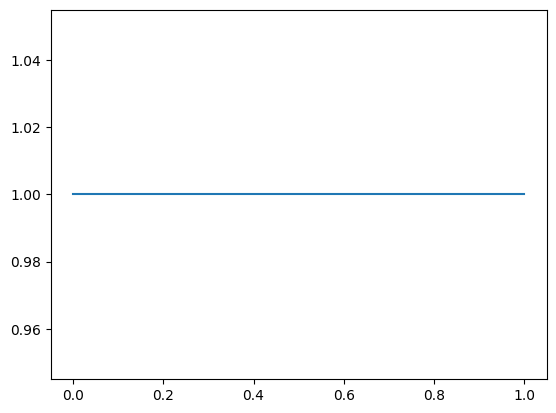

In [36]:
plot_beta(1, 1)

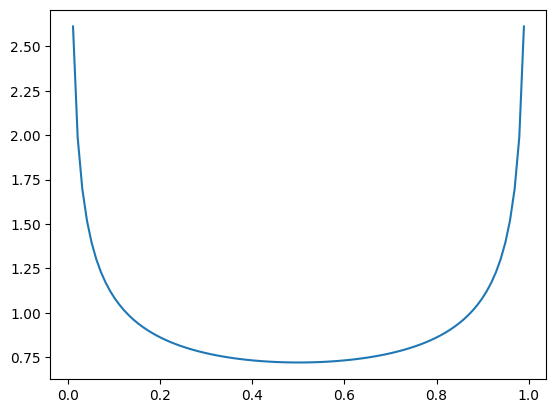

In [37]:
plot_beta(0.6, 0.6)

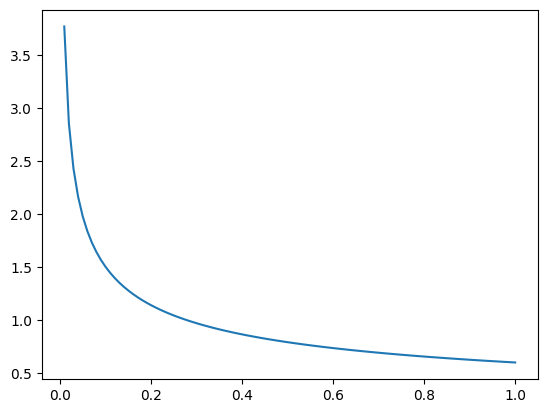

In [38]:
plot_beta(0.6, 1)

In [39]:
def posterior(m, n, a, b):
    theta = np.linspace(0, 1, 100)
    return theta**(a + m - 1) * (1 - theta)**(b + n -m -1)

画个图，看看后验概率密度长啥样，以及后验概率密度随着先验的变化

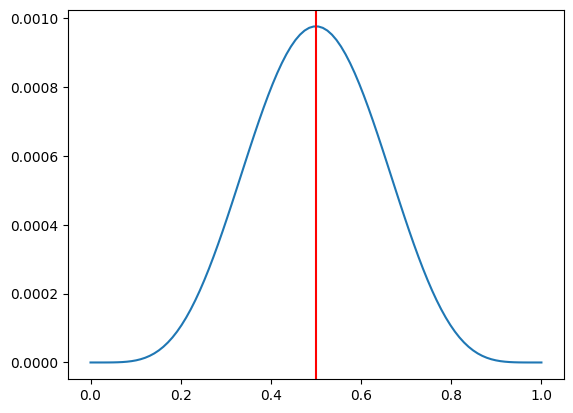

In [40]:
plt.plot(np.linspace(0, 1, 100), posterior(5, 10, 1, 1))
plt.axvline(5 / 10, color='r')

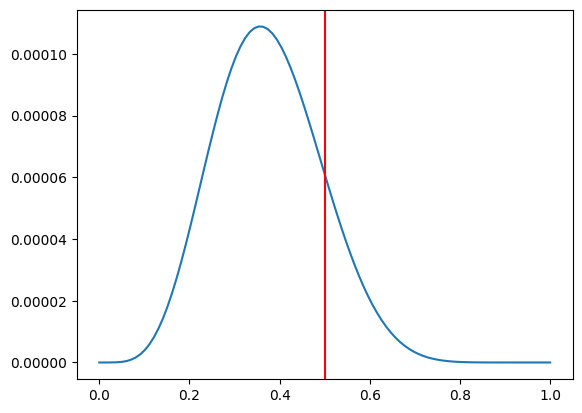

In [41]:
plt.plot(np.linspace(0, 1, 100), posterior(5, 10, 1, 5))
plt.axvline(5 / 10, color='r')

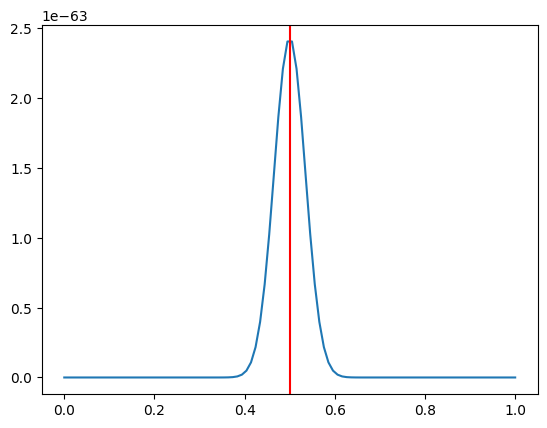

In [42]:
plt.plot(np.linspace(0, 1, 100), posterior(5, 10, 100, 100))
plt.axvline(5 / 10, color='r')

emcee Developers. n.d.. emcee: The MCMC Hammer. emcee Documentation. https://emcee.readthedocs.io/en/stable/



In [43]:
import emcee

import scipy as sp
from scipy.integrate import quad
def tmp_fuc(x, m, n, a, b):
    return x**(a + m - 1) * (1 - x)**(b + n -m -1)


def posterior(x, m, n, a, b):
    # 这里要加一个检测x范围，要不然mcmc的值会跑到范围外
    # 还不能传一个0，要不然还是会报错
    if x < 0 or x > 1:
        return -np.inf
    
    # 做一个归一化
    return tmp_fuc(x, m, n, a, b) / quad(tmp_fuc, 0, 1, args=(m, n, a, b))[0]
    


sampler = emcee.EnsembleSampler(
    3, 1,
    lambda x: posterior(x, 5, 10, 1, 5)
)

sampler.run_mcmc(initial_state=[[0.1], [0.9], [0.5]], nsteps=200000)

State([[0.34344954]
 [0.28969064]
 [0.36216792]], log_prob=[3.25299217 2.82004137 3.2693578 ], blobs=None, random_state=('MT19937', array([2378051879, 1057985004,  497608978, 1940469829, 2431673823,
       3057014605,  219053279,  176909101, 2416008250, 2559171125,
       3198347289, 1643602939, 1889912860, 3153594738, 2580083327,
       2297996787, 3363799603, 3098222591, 3293926671, 3897927142,
       1561497961, 2498935481,  857162902, 4020587516, 2035160841,
       1794677255,   54502561, 3750969943, 1876020840, 2282532255,
        690076819, 2876025539, 1669217031, 3670718703, 2265222892,
       3805559411, 3912200636, 1116194749, 2046638499, 2283480458,
        425444706,  139131383, 3022870089, 1670127177, 3675629801,
        970246089,  704075812, 2839474884, 2259613059,  445147676,
       2516715486, 1184184203,  578673038, 2409996488, 2354045883,
       2090052452, 3474179047,  220856404,  526069734,  440140599,
       4175216100, 2356528035, 1805698474, 3458109955, 428258396

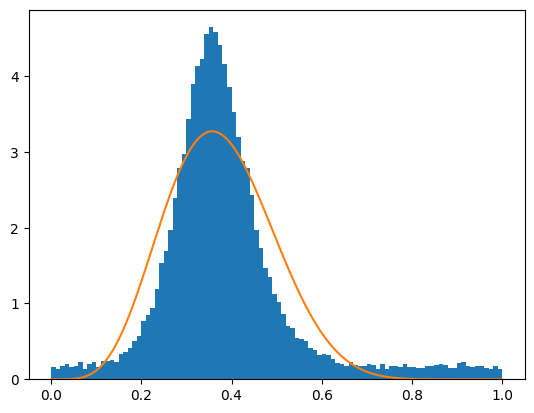

In [44]:
import matplotlib.pyplot as plt

_ = plt.hist(sampler.get_chain(discard=100, thin=15, flat=True), bins=100, density=True, range=[0, 1])

theta_new = np.linspace(0, 1, 10000)
def posterior(x, m, n, a, b):
    # python没重载，但是我又不想过多改动之前的代码
    return tmp_fuc(x, m, n, a, b) / quad(tmp_fuc, 0, 1, args=(m, n, a, b))[0]
plt.plot(theta_new, posterior(theta_new, 5, 10, 1, 5))

# 显然，可以看出，mcmc的数据的峰值是一样的，但是宽度不一样
# mcmc的mean和std如下

In [45]:
np.mean(sampler.get_chain(discard=100, thin=15, flat=True))

0.3878140593391835

In [46]:
np.std(sampler.get_chain(discard=100, thin=15, flat=True))

0.1501472750339373

# 计算原函数的mean和std
# 显然
$$
\begin{align}
    E[x] = \int_0^1 x f(x) dx
    \\
    V[x] = \sqrt{E[x^2] - E[x]^2}
\end{align}
$$

In [47]:
quad(lambda x: x * posterior(x, 5, 10, 1, 5), 0, 1)[0]

0.37500000000000006

In [48]:
np.sqrt(quad(lambda x: x**2 * posterior(x, 5, 10, 1, 5), 0, 1)[0] - quad(lambda x: x * posterior(x, 5, 10, 1, 5), 0, 1)[0]**2)

0.11741705457846556

# 显然，均值差的不多（有可能在算积分的时候有误差），标准差偏差较大